## Car-Following trajectory analysis

- Goal: Extract the acceleration histogram during car-following periods

- Sources of data:

1. [The I-24 Motion dataset](https://i24motion.org/), [paper](https://i24motion.org/)
    - Among all the different dates for which the data was made available, 4 hours of November-22, 2022 was used.
    - The original sampling rate of this dataset is 0.04 second per timestep. This is linearly interpolated to obtain and standard 0.1 second per timestep.

2. [The revised NGSIM dataset](https://u.osu.edu/coifman.1/data-sets/), [paper](https://www.sciencedirect.com/science/article/pii/S0191261517300838)
    - Among the various highways/ roads in the original NGSIM dataset, the revised version only provides revised data for I-80 freeway for one camera (camera 6), in one time window 4:00 PM to 4:15 PM. So 15 minutes of data is used.
    

| Data Source                  | Duration | Length | Lanes | speed limit | Traverse distance | Original Sampling rate | 
|------------------------------|------------------|----------------|-------|---------------|---------------| ---------------|
| The I-24 Motion dataset     |   -    |   -  |   -    |    70 mph  |   -  |  0.04   |
| The revised NGSIM dataset   |   -    |   -  |    -   |    -   |  -    |  0.1    |


----

Car following filter used to extract car-following periods:

- Vehicle types: 
    - For I-24: vehicle class 0: sedan, 1: midsize
    - For Revised NGSIM
- 

Even 4 hours of data is too much, just consider 1 hour of data

In [1]:
import os
import ijson 
import bigjson
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from pathlib import Path
import seaborn as sns
sns.set_style("whitegrid")
datapath = './Data/i_24/637c399add50d54aa5af0cf4__post2.json'

## First: I-24 Motion dataset
Notes: 
- Data covers both directions with multiple lanes
- 

<img width="900" alt="1" src="https://github.com/poudel-bibek/AI-Assignments/assets/96804013/2ef05f8f-c2c7-4350-91dc-fdd5c30fd705">

Total: 14

In [ ]:
with open(datapath, 'rb') as file:
    json_data = bigjson.load(file)
    
    datum = json_data[10]

    # What are the various keys in data
    keys = datum.keys()
    print(f"Total: {len(keys)}\n")
    for i in range(len(keys)):
        print(f"{i+1}: {keys[i-1]}")
    
    print("\n\n")
    for key, value in datum.iteritems():
        print(key, value)

file.close()

# Extra 9
# 'coarse_vehicle_class', 'fine_vehicle_class', 'x_score', 'y_score', 'compute_node_id', 'local_fragment_id', 'merged_ids', 'road_segment_ids', 'flags'


### Step 1: Resample + Save only the required data to CSV
- Linear interpolation seems difficult:
    - Computationally expensive (crashes the notebook)  
    - Time consuming compared to resampling
    - Cant get precise 0.1 intervals (shocking), np.arange can only generate 0.1, 0.
    - Resampling only has a small error at every other data point by 0.02 seconds (first data point is 0.0, then 0.12, then 0.20, then 0.32)

In [ ]:
#create a vehicle_id, x_position, y_position, timestamp 2D numpy array

# Approach 1 : Set threshold
# Open the JSON file
# with open(datapath, 'r') as file:
#     # Parse the JSON objects one by one
#     parser = ijson.items(file, 'item')
#     all_data = []

#     threshold = 50000 #Number of vehicles
#     i = 0
#     while i < threshold:
#         datum = next(parser)

#         id = datum["_id"]['$oid']
#         timestamp = datum["timestamp"]
#         x_position = datum["x_position"]
#         y_position = datum["y_position"]
#         class_fine = datum["fine_vehicle_class"]
#         class_coarse = datum["coarse_vehicle_class"]
#         direction = datum["direction"]
        
#         length = len(timestamp)
#         for j in range(length):

#             data_point = [id, timestamp[j], x_position[j], y_position[j], class_fine, class_coarse, direction]
#             #print(data_point)
#             all_data.append(data_point)

#         # i is indexing the original dataset
#         i += 1
        
#     all_data = np.array(all_data) 
# file.close()
#print(all_data.shape)

# Approach 2: Process all data
# Open the JSON file
# with open(datapath, 'r') as file:
#     # Parse the JSON objects one by one
#     parser = ijson.items(file, 'item')
#     all_data = []

#     try:
#         while True:  # This makes the loop run indefinitely
#             datum = next(parser)

#             id = datum["_id"]['$oid']
#             timestamp = datum["timestamp"]
#             x_position = datum["x_position"]
#             y_position = datum["y_position"]
#             class_fine = datum["fine_vehicle_class"]
#             class_coarse = datum["coarse_vehicle_class"]
#             direction = datum["direction"]
            
#             length = len(timestamp)
#             for j in range(length):
#                 data_point = [id, timestamp[j], x_position[j], y_position[j], class_fine, class_coarse, direction]
#                 all_data.append(data_point)
            
#     except StopIteration:
#         print("All data has been processed.")
#     finally:
#         file.close()
# print(all_data.shape)

# Common code for both approaches
# df = pd.DataFrame(all_data, columns=['id', 'timestamp', 'x_position', 'y_position', 'class_fine', 'class_coarse', 'direction'])
# # Adding a new column 'float_timestamp' where timestamps are converted to float
# df['float_timestamp'] = df['timestamp'].apply(float) 
# pd.set_option('display.float_format', '{:.4f}'.format)

# df = df.drop(['timestamp'], axis=1)
# df.head(20)

In [ ]:
# Approach 1 does not process all data and Approach 2 runs out of memory (Even 70GB RAM is not enough) 
# Approach 3: Process data in chunks
chunk_size = 10000000  # 10 million
columns=['id', 'timestamp', 'x_position', 'y_position', 'class_fine', 'class_coarse', 'direction']

def process_datum(datum):
    data_points = []
    id = datum["_id"]['$oid']
    timestamp = datum["timestamp"]
    x_position = datum["x_position"]
    y_position = datum["y_position"]
    class_fine = datum["fine_vehicle_class"]
    class_coarse = datum["coarse_vehicle_class"]
    direction = datum["direction"]
    
    length = len(timestamp)
    for j in range(length):
        data_point = [id, timestamp[j], x_position[j], y_position[j], class_fine, class_coarse, direction]
        data_points.append(data_point)
        
    return data_points

# Open the JSON file
with open(datapath, 'r') as file:
    # Parse the JSON objects one by one
    parser = ijson.items(file, 'item')
    chunks = []
    
    # start by adding a header 
    temp_df = pd.DataFrame(columns=columns)
    temp_df.to_csv('temporary_chunks.csv', mode='a', header=True, index=False)
    
    try:
        i = 1
        while True:
            datum = next(parser)
            chunks.extend(process_datum(datum))
            
            if len(chunks) >= chunk_size:
                temp_df = pd.DataFrame(chunks, columns=columns)
                temp_df.to_csv('temporary_chunks.csv', mode='a', header=False, index=False)  # Saving chunks to a temporary file
                chunks = []
                print(f"Chunk {i}, {i*10}M data processed.")
                i += 1
                
    except StopIteration:
        print("All data has been processed.")
        
    finally:
        if chunks:  # Saving remaining data
            temp_df = pd.DataFrame(chunks, columns=columns)
            temp_df.to_csv('temporary_chunks.csv', mode='a', header=False, index=False)
        file.close()

In [ ]:
df = pd.read_csv('temporary_chunks.csv')

# Converting 'timestamp' to numeric values, setting errors='coerce' to handle non-numeric values
df['float_timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')

# Dropping the original 'timestamp' column
df = df.drop(['timestamp'], axis=1)

pd.set_option('display.float_format', '{:.4f}'.format)
df.head(20)

In [ ]:
# Summary of data, what values can variables take
print(f"Unique ids (Before): {len(df['id'].unique())}\n")
print(f"Fine: {df['class_fine'].value_counts()}\n")
print(f"Coarse classes (Before):\n{df['class_coarse'].value_counts()}")

# Fine class can be dropped (no use)
df = df.drop(['class_fine'], axis=1)

# Filter data by class only keep class 0 and 1
df = df[df['class_coarse'].isin([0, 1])]
print(f"Unique ids (After): {len(df['id'].unique())}\n")
print(f"\nCoarse After (After):\n{df['class_coarse'].value_counts()}")

# Corse class can also be dropped (made use of it)
df = df.drop(['class_coarse'], axis=1)

print(f"Shape of new data: {df.shape}")

In [ ]:
# Resample
new_df = pd.DataFrame(columns=['id', 't', 'x', 'y', 'direction'])

# Create a list to temporarily store the rows
rows_to_append = []

# Number of rows to process before printing a progress update
progress_interval = 10000000 # 10 million

# Iterating over DataFrame rows as tuples
for i, row in enumerate(df.itertuples(index=False)):
    
    if i % progress_interval == 0:
        print(f"Processed {i} rows so far...")
    
    # Check if rows_to_append is not empty and if the id is the same as the previous one
    if rows_to_append and row.id == rows_to_append[-1]['id']:
        if str(row.float_timestamp)[11] != str(rows_to_append[-1]['t'])[11]:
            rows_to_append.append({'id': row.id, 't': row.float_timestamp, 'x': row.x_position, 'y': row.y_position, 'direction': row.direction})
    else:
        rows_to_append.append({'id': row.id, 't': row.float_timestamp, 'x': row.x_position, 'y': row.y_position, 'direction': row.direction})

# Convert the list of dictionaries into a DataFrame
new_df = pd.DataFrame(rows_to_append)

print(f"Processing complete. {len(new_df)} rows added.")
new_df.head(20)


In [ ]:
# Save to csv file
new_df.to_csv('./Data/i_24/resampled_i24.csv', header=True, index=False)
# From the initial 247 million data points, reduced to 74 million.

### Step 2: Remove extra lanes and assign lane ids

In [28]:
loaded_df = pd.read_csv('./Data/i_24/resampled_i24.csv')
loaded_df.head(20)

subset_df = loaded_df #.iloc[:1000000].copy()

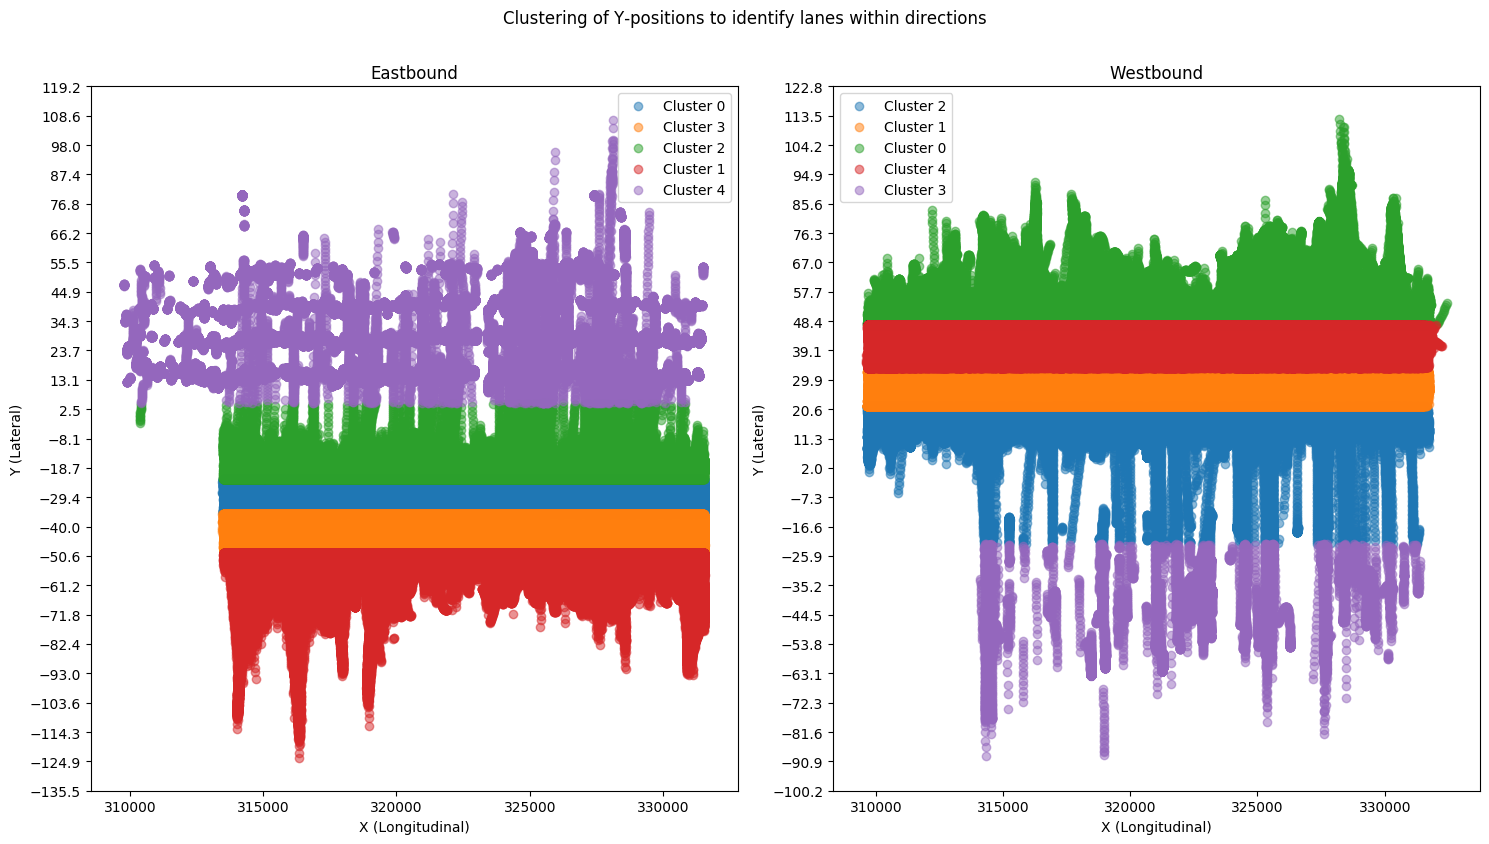

In [4]:
directions = subset_df['direction'].unique()
direction_mapping = {-1: 'Westbound', 1: 'Eastbound'}

plt.figure(figsize=(15, 8))  # Adjusted size for two subplots

lane_definitions = {}

for index, direction in enumerate(directions):
    plt.subplot(1, 2, index + 1)  # 1 row, 2 columns, subplot index

    direction_df = subset_df[subset_df['direction'] == direction].copy()
    num_clusters = 5

    kmeans = KMeans(n_clusters=num_clusters)
    direction_df['cluster'] = kmeans.fit_predict(direction_df[['y']])

    for cluster_id in direction_df['cluster'].unique():
        cluster_data = direction_df[direction_df['cluster'] == cluster_id]
        plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster_id}', alpha=0.5)

    sorted_centroids = sorted(kmeans.cluster_centers_[:, 0])
    lane_boundaries = []
    for i in range(len(sorted_centroids) - 1):
        boundary = (sorted_centroids[i] + sorted_centroids[i + 1]) / 2
        lane_boundaries.append(boundary)

    lane_definitions[direction_mapping[direction]] = lane_boundaries

    # Calculate the y-tick locations
    y_min, y_max = plt.ylim()
    y_interval = (y_max - y_min) / 24
    y_ticks = [y_min + i * y_interval for i in range(25)]
    plt.yticks(y_ticks)

    plt.xlabel('X (Longitudinal)')
    plt.ylabel('Y (Lateral)')
    plt.title(f'{direction_mapping[direction]}')
    plt.legend()

plt.tight_layout()
plt.suptitle('Clustering of Y-positions to identify lanes within directions', y=1.05) 
plt.show()


# Preliminary Lane ranges
# print("Premliminary Lane Ranges\n")
# for direction, boundaries in lane_definitions.items():
#     print(f"{direction} Lane Boundaries:")
#     for i, boundary in enumerate(boundaries):
#         if i == 0:
#             size = boundary - y_min
#             print(f"Lane 1: < {boundary} (Size: {size:.2f})")
#         else:
#             size = boundary - boundaries[i-1]
#             print(f"Lane {i+1}: {boundaries[i-1]} to {boundary} (Size: {size:.2f})")
    
#     size = y_max - boundaries[-1]
#     print(f"Lane {len(boundaries)+1}: > {boundaries[-1]} (Size: {size:.2f})")
#     print("\n")

<img width="700" alt="poles_lanes" src="https://github.com/poudel-bibek/AI-Assignments/assets/96804013/71b81420-6dbe-46f8-a2aa-d599241913c1">
<p>
From the real-world: Its mostly always 4 lane

Remove the entire vehicle if:
- For any vehicle Westbound (-1), if a trajectory has a value lower than -60 or higher than -8
- For any vehicle Eastbound (1), if a trajectory has a value lower than  2 or higher than 58

__further revise the lane boundaries as follows__
__The typical size of a lane in interstate highways is 12 ft, use the Figure below from the paper as well__

<img width="700" alt="paper_lanes" src="https://github.com/poudel-bibek/4-Degrees-Of-Freedom/assets/96804013/51bba06b-acef-4ffb-9198-3044e469f425
">

This figure in the paper is misleading/ confusing (It does say that its just of a couple sections). I am not following the figure for lane demarcations, following what is shown below.

| Lane | Westbound      | Eastbound        |
|------|----------------|------------------|
| 1    |   3 to 15      | -9 to -21        |
| 2    |   16 to 28     | -22 to -34       |
| 3    |   29 to 41     | -35 to -47       |
| 4    |   42 to 54    | -48 to -60       |

In [22]:
# Define the thresholds
upper_threshold_east = -8 #54
lower_threshold_east = -60 # 2

upper_threshold_west = 54 #-8
lower_threshold_west = 2 #-64

# Remove vehicles that don't meet the criteria
# This will also remove the vehicles that at any point exit the highway
to_remove_east = subset_df[
    (subset_df['direction'] == 1) & # Eastbound 
    ((subset_df['y'] > upper_threshold_east) | (subset_df['y'] < lower_threshold_east)) # Data points to remove
]['id'].unique()

to_remove_west = subset_df[
    (subset_df['direction'] == -1) & # Westbound
    ((subset_df['y'] > upper_threshold_west) | (subset_df['y'] < lower_threshold_west)) # Data points to remove
]['id'].unique()

subset_df = subset_df[~subset_df['id'].isin(to_remove_east)]
subset_df = subset_df[~subset_df['id'].isin(to_remove_west)]

print(f"Shape of the remaining data: {subset_df.shape}")
# 62 million data points

Shape of the remaining data: (62057469, 5)


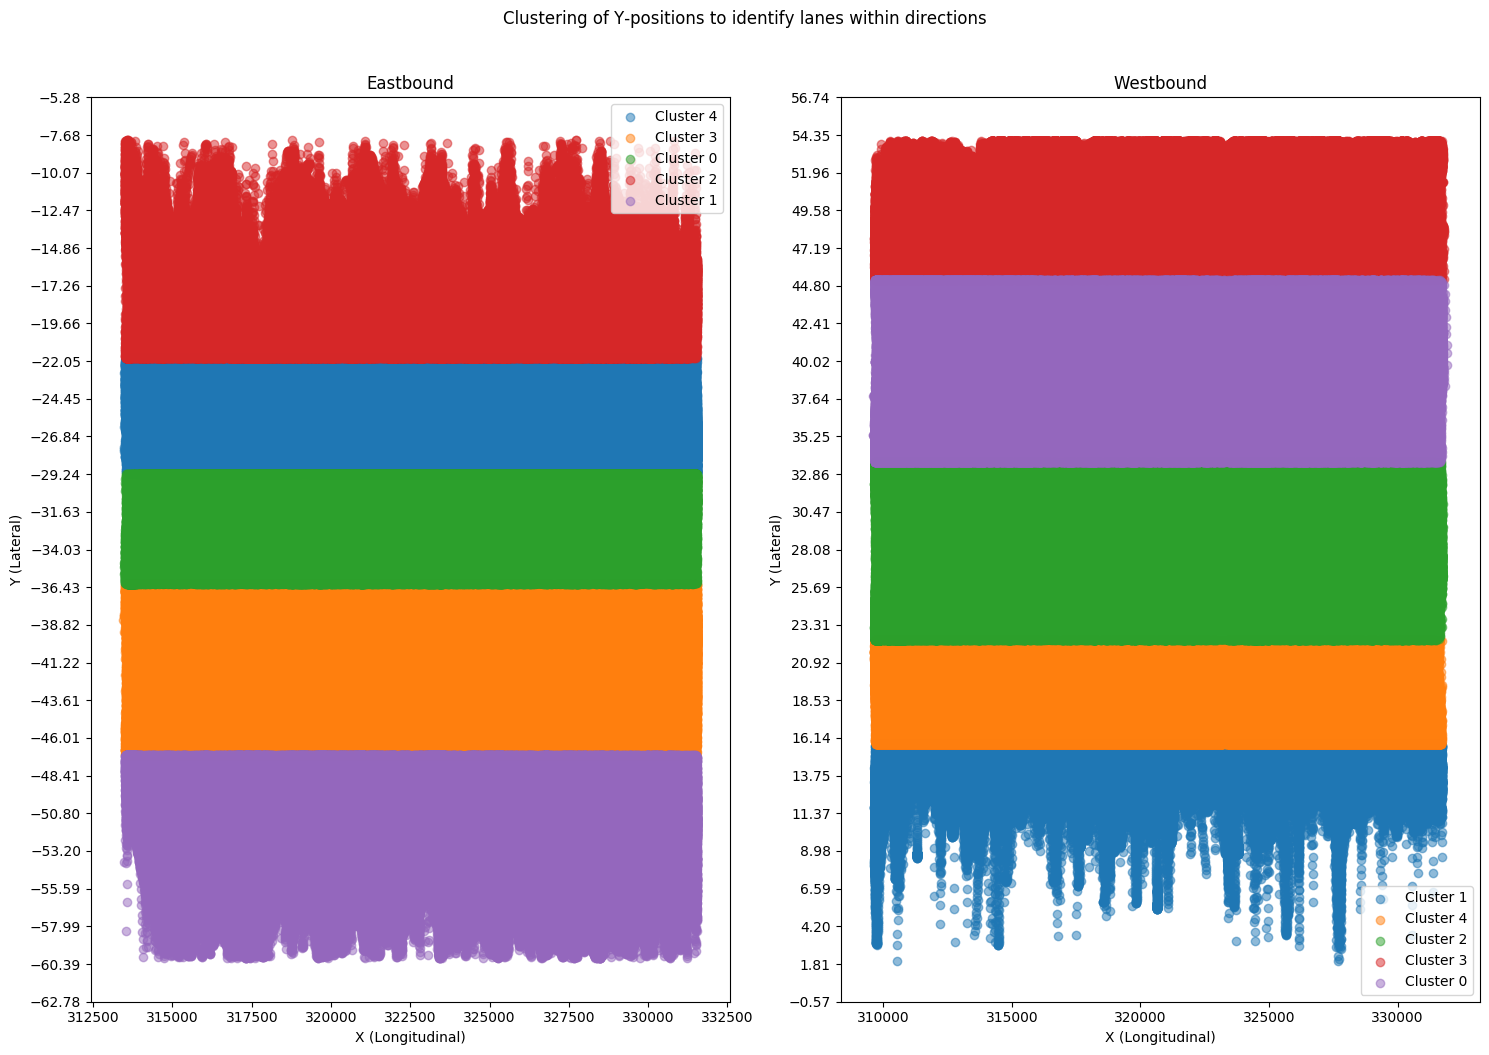

In [23]:
# redo the clustering plot for validation
directions = subset_df['direction'].unique()
direction_mapping = {-1: 'Westbound', 1: 'Eastbound'}

plt.figure(figsize=(15, 10))  # Adjusted size for two subplots

lane_definitions = {}

for index, direction in enumerate(directions):
    plt.subplot(1, 2, index + 1)  # 1 row, 2 columns, subplot index

    direction_df = subset_df[subset_df['direction'] == direction].copy()
    num_clusters = 5

    kmeans = KMeans(n_clusters=num_clusters)
    direction_df['cluster'] = kmeans.fit_predict(direction_df[['y']])

    for cluster_id in direction_df['cluster'].unique():
        cluster_data = direction_df[direction_df['cluster'] == cluster_id]
        plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster_id}', alpha=0.5)

    sorted_centroids = sorted(kmeans.cluster_centers_[:, 0])
    lane_boundaries = []
    for i in range(len(sorted_centroids) - 1):
        boundary = (sorted_centroids[i] + sorted_centroids[i + 1]) / 2
        lane_boundaries.append(boundary)

    lane_definitions[direction_mapping[direction]] = lane_boundaries

    # Calculate the y-tick locations
    y_min, y_max = plt.ylim()
    y_interval = (y_max - y_min) / 24
    y_ticks = [y_min + i * y_interval for i in range(25)]
    plt.yticks(y_ticks)

    plt.xlabel('X (Longitudinal)')
    plt.ylabel('Y (Lateral)')
    plt.title(f'{direction_mapping[direction]}')
    plt.legend()

plt.tight_layout()
plt.suptitle('Clustering of Y-positions to identify lanes within directions', y=1.05) 
plt.show()

In [33]:
def assign_lane_vectorized(y_values, directions):
    # Define boundaries. These dont match the table (but to make the output match, because of how left, right work below they have to be set this way)
    eastbound_boundaries = np.array([-8, -21, -34, -47, -60])  # 1
    westbound_boundaries = np.array([2, 16, 29, 42, 55])       # -1

    # Prepare output array
    lanes = np.zeros_like(y_values, dtype=np.int)

    # For Eastbound: directions == 1
    # Invert the eastbound_boundaries to ascending order for searchsorted
    ascending_boundaries_east = eastbound_boundaries[::-1]
    eastbound_indices = np.searchsorted(ascending_boundaries_east, y_values, side='right')
    eastbound_lanes = len(ascending_boundaries_east) - eastbound_indices

    # For Westbound: directions == -1
    westbound_lanes = np.searchsorted(westbound_boundaries, y_values, side='left')

    # Assign lanes based on direction
    lanes[directions == 1] = eastbound_lanes[directions == 1]
    lanes[directions == -1] = westbound_lanes[directions == -1]

    # There should be no values outside the range
    # Handle values outside the boundaries for eastbound
    #lanes[(directions == 1) & (y_values > -8)] = 0
    #lanes[(directions == 1) & (y_values < -60)] = 5

    # Handle values outside the boundaries for westbound
    #lanes[(directions == -1) & (y_values < 2)] = 0
    #lanes[(directions == -1) & (y_values > 54)] = 5

    return lanes

# Apply the function and assign the lane IDs
subset_df['lane_id'] = assign_lane_vectorized(subset_df['y'].values, subset_df['direction'].values)

# Save this to a CSV file
subset_df.to_csv('./Data/i_24/processed_i24.csv', header=True, index=False)

# Display the first few rows
pd.set_option('display.float_format', '{:.4f}'.format)
print(subset_df.head())


   direction                        id               t           x        y  \
0          1  638b7938a8730ec3e174b314 1669118503.9000 320092.6203 -28.6147   
1          1  638b7938a8730ec3e174b314 1669118504.0200 320107.4724 -28.5595   
2          1  638b7938a8730ec3e174b314 1669118504.1000 320117.3994 -28.5077   
3          1  638b7938a8730ec3e174b314 1669118504.2200 320132.3289 -28.4075   
4          1  638b7938a8730ec3e174b314 1669118504.3000 320142.3081 -28.3257   

   lane_id  
0        2  
1        2  
2        2  
3        2  
4        2  


### Step 3: Find leader, more processe get headway
- Y values are not needed drop them
- Convert x values to meters 
- In the same timesteps, leader is going in same direction as ego vehicle with difference in x
- Leader is in the same lane as the ego vehicle
- The difference in x_position is the headway

In [2]:
# load data
processed_df = pd.read_csv('./Data/i_24/processed_i24.csv')

# How are lanes distributed?
# print(processed_df['lane_id'].value_counts())

# # Check for Nan or missing values
# print(processed_df.isnull().sum())

2    22367669
1    17311743
3    15306983
4    15094891
5     3912846
0      257020
Name: lane_id, dtype: int64
direction    0
id           0
t            0
x            0
y            0
lane_id      0
dtype: int64


In [3]:
# find leader and add the id and headway, if no leader then -1 
# Around the same time stamp, the leader travels the same lane as ego vehicle with a difference in x position
# Only cosidered a leader if the difference in x position is positive 150m
# Eastbound (1) or Westbound (-1), x-values are always positive. 
# In Westbound, the leader will have a x-value higher than follower
# In Eastbound, the leader will have a x-value lower than follower

# What if there are multiple leaders?
# For now, we will only consider the closest leader. But how to get the closest leader?
# We can sort the leader dataframe by x-value and take the first row.

def find_leader(group, threshold):

    # Initialize the leader DataFrame with the same index as group
    leader_df = pd.DataFrame(index=group.index)
    leader_df['leader'] = -1
    leader_df['headway'] = -1

    # Iterate over the unique IDs directly
    for unique_id in group['id'].unique():
        current_vehicle = group[group['id'] == unique_id]
        x_value = current_vehicle['x'].iloc[0]
        direction = current_vehicle['direction'].iloc[0]

        # Define masks for potential leaders based on direction
        mask_eastbound = (group['x'] < x_value) & (group['direction'] == 1)
        mask_westbound = (group['x'] > x_value) & (group['direction'] == -1)
        mask_potential_leaders = mask_eastbound if direction == 1 else mask_westbound

        # Find potential leaders
        potential_leaders = group[mask_potential_leaders].copy()
        if not potential_leaders.empty:
            potential_leaders['x_diff'] = (potential_leaders['x'] - x_value).abs()
            leader = potential_leaders[potential_leaders['x_diff'] < threshold].nsmallest(1, 'x_diff')

            if not leader.empty:
                leader_index = group[group['id'] == unique_id].index
                leader_df.loc[leader_index, 'leader'] = leader['id'].values[0]
                leader_df.loc[leader_index, 'headway'] = leader['x_diff'].values[0]

    # Concatenate the group data with the leader data
    result = pd.concat([group.reset_index(drop=True), leader_df.reset_index(drop=True)], axis=1)
    return result

# Open CSV file for appending results
csv_file_path = Path('./Data/i_24/second_processed_i24.csv')
csv_exists = csv_file_path.exists()

groups = processed_df.groupby(['t', 'lane_id', 'direction'])

# Pre-calculate the number of groups to avoid recomputing it every iteration
print("Total groups:", len(groups))

# Process the dataframe in chunks
group_count = 0
threshold = 150
results = []  # Initialize a list to store intermediate dataframes

for name, group in groups:
    group_count += 1 
    results.append(find_leader(group, threshold))

    # Check if we've processed 10000 groups, or if we are at the last one. 
    if group_count % 10000 == 0:

        print(f"Processing chunk at group #{group_count}: t={group['t'].iloc[0]}")

        # Concatenate all the dataframes in the list
        result_df = pd.concat(results, ignore_index=True)
        
        # Write the result_df to CSV file in append mode
        result_df.to_csv(csv_file_path, mode='a', header=not csv_exists, index=False)
        
        csv_exists = True

        # Clear the list for the next chunk
        results = []

# If there are any remaining groups that haven't been written after the loop
if results:
    result_df = pd.concat(results, ignore_index=True)
    with open(csv_file_path, 'a') as f:
        result_df.to_csv(f, header=not csv_file_path.exists(), index=False)

Total groups: 5842992


KeyboardInterrupt: 

### Step 4: Calculate Velocity and Acceleration of ego vehicle
- Needs initial two values to be removed (because of differentiation twice) for every data point (to avoid having Nan)

In [ ]:
# load last_processed_i24
new_df = pd.read_csv('./Data/i_24/second_processed_i24.csv')

# drop y_values
new_df = new_df.drop(['y'], axis=1)

# Convert x in ft to meters
new_df['x'] = new_df['x'] * 0.3048

pd.set_option('display.float_format', '{:.4f}'.format)
new_df.head(50)

In [ ]:
# Check if the headway values worked correctly for eastbound and westbound

### Step 5: Apply remaining of the car-following filter
- A car has a leader
- Both leader and follower remain in the same lane for > 10s
- No cut ins, i.e., the leader does not change in the period
- Follower speed is greater than 10% of the speed limit (in m/s) to avoid approach to standing traffic.
- Apply 2 second rule to the speed limit (in m/s) to find a headway distance where you can avoid free-flow conditions.